# Living Decisions

## Introduction

I'm about to graduate from The Fletcher School, and I want to make sure that IF I return to Boston post-covid, I find the right place to live. Enter this short, somewhat silly project. The purpose of this analysis is to determine where I should, based on factors I have identified as particularly important to my own individual happiness, including:

- **Impervious surface** - The more impervious surfaces there are, the less green space there is. I'd like a lot of green space.
- **Boston land cover** - The lower the intensity of a developed area, the better - but it does have to be developed.
- **Tree canopy** - Trees have previously been directly linked to my happiness.
- **Proximity to farmers markets** - I like to have fresh veggies and fresher baked goods every weekend.
- **Proximity to libraries** - Crucial for recouping the amount of money I expended on books in grad school.
- **Proximity to restaurants** - Having lived in a rural town with little access to restaurant food for the last year, I'd like some good ones close by.
- **Resident age** - Some of my happiness is based on making friends. While that is aboslutely not limited to a certain age bracket, it would be nice to have young-ish people to hang out with.

## The Data

In case you would like to investigate the data I used for myself, you'll find it in the `data` folder, which contains the following files:

**Variables**

- `data/raster/NLCD/NLCD_2016_Impervious_Boston.tif` - impervious surface raster for Boston and the surrounding area (GeoTIFF)
- `data/raster/NLCD/NLCD_2016_Land_Cover_Boston.tif` - land cover raster for Boston and the surrounding area (GeoTIFF)
- `data/raster/NLCD/NLCD_Land_Cover_Legend.jpg` - the key for the land cover raster (JPG)
- `data/raster/NLCD/NLCD_2016_Tree_Canopy_Boston.tif` - tree canopy raster for Boston and the surrounding area (GeoTIFF)
- `data/vector/MassGIS/FARMERSMARKETS_PT/FARMERSMARKETS_PT.shp` - farmers markets of Boston (ESRI shapefile)
- `data/vector/MassGIS/LIBRARIES_PT/LIBRARIES_PT.shp` - Boston libraries (ESRI shapefile)
- `OpenStreetMap restaurant data for the Boston region` - Boston region restaurants (OpenStreetMap import)
- `data/tabular/ACSST5Y2019.S0101/ACSST5Y2019.S0101_data_with_overlays.csv` - resident age data by zip code for Boston (.csv)

**Maps**
- `data/vector/Census/tl_2010_25_zcta510/tl_2010_25_zcta510.shp` - zip code boundaries shapefile for Boston (ESRI shapefile)
- `data/vector/MassGIS/OUTLINE25K_POLY/OUTLINE25K_POLY.shp` - Massachusetts outline
- `data/vector/MassDOT/MPO_Boundaries/MPO_Boundaries.shp` - Metropolital Planning Organization (MPO) boundaries

## Analysis Overview

Here is a rough outline of the analysis I will perform:

1. Read in and visualize the raster datasets
2. Find the zip codes we'll be working with
2. **Impervious surface area** > reclassify for impervious surface preferences (more impervious = less desirable)
3. **Land cover** > reclassify for land cover preferences
4. **Tree canopy** > reclassify for tree canopy preferences
5. **Farmers markets** > rasterize shapefile > get euclidean distance raster > reclassify (close = more desirable)
6. **Libraries** > rasterize shapefile > get euclidean distance raster > reclassify (close = more desirable)
7. **Restaurants** > pull restaurant data from OpenStreetMap > rasterize shapefile > get euclidean distance raster > reclassify (close = more desirable)
8. **Resident age** > calculate average age by zip code > join to zip code shapefile > rasterize shapefile > reclassify (close to 30 = more desirable)
9. Calculate weighted and unweighted desirability raster from all of the reclassified rasters
10. Mask desirability rasters to the shape of Boston
11. Use zonal stats to determine the average desirability by zip code

## Import Dependencies

In [309]:
import rasterio
from rasterio.plot import show
from rasterio import features
import osmnx as ox

import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

from scipy import ndimage
from rasterstats import zonal_stats

## Raster Checks

Before I get started with my variables, I want to check to see if all three of the rasters I'll be using have the same metadata, and load the metadata from one of them.

In [12]:
# Open all three rasters, check that their metadata is equivalent

with rasterio.open('data/raster/NLCD/NLCD_2016_Impervious_Boston.tif') as impervious_check:
    impervious_meta = impervious_check.meta
with rasterio.open('data/raster/NLCD/NLCD_2016_Land_Cover_Boston.tif') as landcover_check:
    landcover_meta = landcover_check.meta
with rasterio.open('data/raster/NLCD/NLCD_2016_Tree_Canopy_Boston.tif') as tree_check:
    tree_meta = tree_check.meta

impervious_meta == landcover_meta == tree_meta

True

In [16]:
# Read in the impervious surface area raster and extract the relevant spatial information.

with rasterio.open('data/raster/NLCD/NLCD_2016_Impervious_Boston.tif') as raster:
    bounds = raster.bounds
    crs = raster.crs
    nodata = raster.nodata
    shape = raster.shape
    transform = raster.transform
    res = raster.res
    impervious = raster.read(1)

Great! Let's get started.

## Our map of Boston

Let's see those ZIP code tabulation areas (ZCTAs). I'm also going to convert these to the proper crs, which in this case is EPSG:6491, Massachusetts Mainland, and select only the ZCTAs which are in the Boston area (MPO = Boston Region). To get us started, we'll bring in the outline of Massachusetts - it'll help us to remove any overlap the ZCTAs have with the coastline. 

In [177]:
# Bring in the Massachusetts mainland outline and convert it to EPSG:6491.

outline = gpd.read_file('data/vector/MassGIS/OUTLINE25K_POLY/OUTLINE25K_POLY.shp')
outline.to_crs('epsg:6491', inplace=True)

Now we'll bring in the ZCTAs and clip them according to the official state outline.

In [178]:
# Bring in the ZCTA file and again convert its crs.

zips = gpd.read_file('data/vector/Census/tl_2010_25_zcta510/tl_2010_25_zcta510.shp')
zips.to_crs('epsg:6491', inplace=True)

<AxesSubplot:>

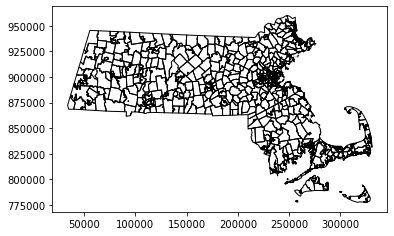

In [198]:
# Let's clip!

zips_intersect = gpd.clip(zips, outline)
zips_intersect.plot(facecolor='none', edgecolor='k')

Great. This will be more precise. Before we can get into just those ZCTAs that make up the Boston area, we have to extract *just* the Boston region from the MA Metropolitan Planning Organizations (MPOs).

In [199]:
# Bring in the MPO boundaries shapefile, select for Boston, and convert it to the proper crs.

mpo = gpd.read_file('data/vector/MassDOT/MPO_Boundaries/MPO_Boundaries.shp')
boston_mpo = mpo[mpo['MPO'] == 'Boston Region'].copy()
boston_mpo.to_crs('epsg:6491', inplace=True)

Beautiful. Now I know that some ZCTA boundaries could cross town (and therefore MPO) borders, so I'm going to find the centroid of each ZCTA and keep only those ZCTAs whose centroids are within the Boston Region MPO.

In [385]:
# Clip those zips!

zips_clipped = zips[zips.centroid.within(boston_mpo.geometry[10])]

<AxesSubplot:>

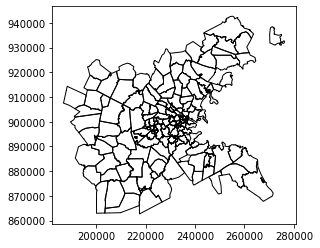

In [201]:
# Let's see 'em!

zips_clipped.plot(facecolor='None', edgecolor='Black')

Let's also create a mask from the Boston Region MPO while we're at it - we'll use it later.

In [432]:
# Rasterize the Boston Region MPO

mask = features.rasterize(boston_mpo['geometry'], out_shape=shape, 
                          fill=np.NaN, transform=transform, default_value=1)

Now we have a map to work with. On to the variables!

## Impervious Surface Area

I loaded the landcover raster above, so let's actually check that metadata and then see what the matrix looks like.

In [14]:
impervious_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 3322,
 'height': 3024,
 'count': 1,
 'crs': CRS.from_epsg(6491),
 'transform': Affine(30.0, 0.0, 181770.0,
        0.0, -30.0, 948390.0)}

In [17]:
impervious

array([[  0,   0,   0, ..., 127, 127, 127],
       [  0,   0,   0, ..., 127, 127, 127],
       [  0,   0,   0, ..., 127, 127, 127],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

Looks pretty solid. Now I want to get rid of all that pesky water on the coast.

In [211]:
# Multiply raster by the mask!

impervious_zip = impervious * mask
impervious_zip

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

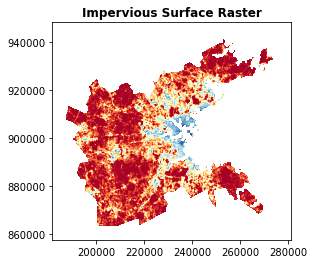

In [431]:
show(impervious_zip, title="Impervious Surface Raster", 
     transform=transform, cmap='RdYlBu')
plt.show()

The values in this raster tell us the percentage of the pixel area that's covered by impervious surfaces. I'm going to reclassify the Impervious Surface Raster to my own tastes - I want to see things that aren't asphalt and experience less flooding. I'd also like to vote for green infrastructure with my feet.

| Min Imperviousness (Inclusive) | Max Imperviousness (Exclusive) |   Suitability Level   | Suitability Score |
| :----------------------------: | :----------------------------: | :-------------------: | :---------------: |
|               ...              |                10%             | Very high suitability |          5        |
|               10%              |                20%             |    High suitability   |          4        |
|               20%              |                60%             |   Medium suitability  |          3        |
|               60%              |                100%            |    Low suitability    |          2        |
|               100%             |                ...             | Very low suitability  |          1        |

In [214]:
# Create a new impervious surface array

impervious_reclass = np.full(shape, np.NaN)

# Reclassify that surface!

impervious_reclass[impervious_zip < 10] = 5
impervious_reclass[(impervious_zip >= 10) & (impervious_zip < 20)] = 4
impervious_reclass[(impervious_zip >= 20) & (impervious_zip < 60)] = 3
impervious_reclass[(impervious_zip >= 60) & (impervious_zip < 100)] = 2
impervious_reclass[impervious_zip >= 100] = 1

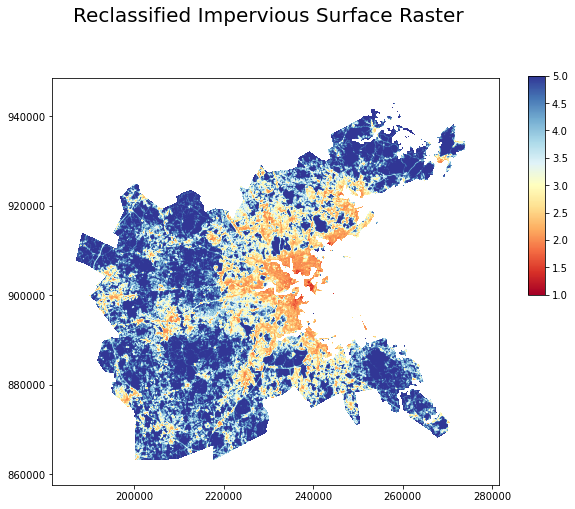

In [281]:
# Let's see what it looks like now!

fig, ax = plt.subplots(figsize=(8,8))
image = ax.imshow(impervious_reclass, cmap="RdYlBu", 
                  extent = (bounds.left, bounds.right, bounds.bottom, bounds.top))
fig.colorbar(image, cax = fig.add_axes([.95, 0.48, 0.03, 0.38]))
fig.suptitle("Reclassified Impervious Surface Raster", fontsize=20)
plt.show()

## Land Cover

Alright, let's load in that land cover raster and get started!

In [217]:
with rasterio.open('data/raster/NLCD/NLCD_2016_Land_Cover_Boston.tif') as land:
    landcover = land.read(1)
landcover

array([[41, 41, 41, ...,  0,  0,  0],
       [41, 41, 41, ...,  0,  0,  0],
       [41, 41, 41, ...,  0,  0,  0],
       ...,
       [43, 43, 43, ..., 11, 11, 11],
       [43, 43, 43, ..., 11, 11, 11],
       [41, 43, 43, ..., 11, 11, 11]], dtype=uint8)

I can see those classifications there already. I'm going to get rid of some of them and just clip the raster to the area I'm interested in. And let's see what that looks like, too.

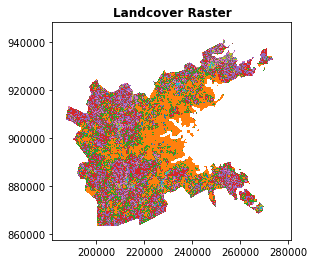

In [246]:
# Mask the landcover! I'm not going to display the raster after this because all of the corners will be NaN.

landcover_zip = landcover * mask

# Visualize the landcover!

show(landcover_zip, title='Landcover Raster', transform=transform, cmap='tab10')
plt.show()

Gorgeous. Now let's reclassify that based on what kind of area I want to live in. The table below shows the land cover types I'll be working with:

| Cell Value |            Land Cover             |
| :--------: | :-------------------------------: | 
|     11     |            Open Water             | 
|     12     |        Perennial Ice/Snow         | 
|     21     |       Developed, Open Space       | 
|     22     |      Developed, Low Intensity     | 
|     23     |     Developed, Medium Intensity   | 
|     24     |      Developed, High Intensity    | 
|     31     |     Barren Land (Rock/Sand/Clay)  | 
|     41     |         Deciduous Forest          | 
|     42     |         Evergreen Forest          | 
|     43     |           Mixed Forest            | 
|     52     |           Shrub/Scrub             | 
|     71     |        Grassland/Herbaceous       | 
|     81     |           Pasture/Hay             | 
|     82     |         Cultivated Crops          | 
|     90     |           Woody Wetlands          | 
|     95     |     Emergent Herbaceous Wetlands  | 


And I'm going to assign suitability scores from one to five to these land cover types based on the values below (just my own personal preferences, really):

|      Land Cover Types     | Land Cover Codes |   Suitability Level   | Suitability Score |
| :-----------------------: | :--------------: | :-------------------: | :---------------: |
|       Developed (all)     |  21, 22, 23, 24  | Very high suitability |          5        |
|           Forest          |    41, 42, 43    |    High suitability   |          4        |
|       Grassland, shrub    |      52, 71      |   Medium suitability  |          3        |
|   Barren land, cropland   |    31, 81, 82    |    Low suitability    |          2        |
| Wetlands, water, ice/snow |  11, 12, 90, 95  | Very low suitability  |          1        |

In [429]:
# Create a new array to work from.

landcover_reclass = np.full(shape, np.NaN)

# Now to reclassify all those land cover types

landcover_reclass[(landcover_zip == 21) | (landcover_zip == 22) \
                | (landcover_zip == 23) | (landcover_zip == 24)] = 5
landcover_reclass[(landcover_zip == 41) | (landcover_zip == 42) \
                | (landcover_zip == 43)] = 4
landcover_reclass[(landcover_zip == 52) | (landcover_zip == 71)] = 3
landcover_reclass[(landcover_zip == 31) | (landcover_zip == 81) \
                | (landcover_zip == 82)] = 2
landcover_reclass[(landcover_zip == 11) | (landcover_zip == 12) \
                | (landcover_zip == 90) | (landcover_zip == 95)] = 1

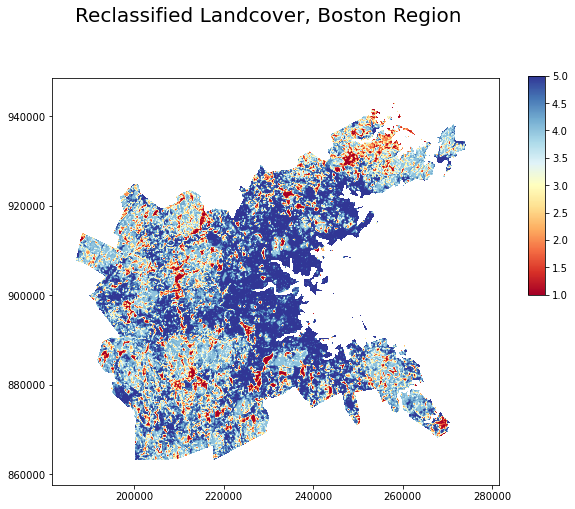

In [430]:
# Let's see what it looks like!

fig, ax = plt.subplots(figsize=(8,8))
image = ax.imshow(landcover_reclass, cmap="RdYlBu", 
                  extent = (bounds.left, bounds.right, bounds.bottom, bounds.top))
fig.colorbar(image, cax = fig.add_axes([.95, 0.48, 0.03, 0.38]))
fig.suptitle("Reclassified Landcover, Boston Region", fontsize=20)
plt.show()

Just about the opposite of the impervious surface raster - but that's okay! Let's keep going. This is great.

## Tree Canopy

Time for trees! Let's load this raster in and see what the trees look like.

In [255]:
with rasterio.open('data/raster/NLCD/NLCD_2016_Tree_Canopy_Boston.tif') as tree:
    trees = tree.read(1)
trees

array([[ 86,  88,  84, ..., 255, 255, 255],
       [ 88,  89,  89, ..., 255, 255, 255],
       [ 85,  89,  88, ..., 255, 255, 255],
       ...,
       [ 85,  84,  89, ...,   0,   0,   0],
       [ 89,  87,  87, ...,   0,   0,   0],
       [ 89,  87,  86, ...,   0,   0,   0]], dtype=uint8)

Looks like 255 is the null value. I'm going to get rid of those and the non-Boston trees, and just clip the raster to the area I'm interested in. And let's see what that looks like, too.

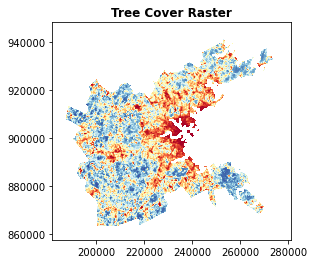

In [257]:
# Mask the landcover! I'm not going to display the raster after this because all of the corners will be NaN.

trees_zip = trees * mask

# Visualize the landcover!

show(trees_zip, title='Tree Cover Raster', transform=transform, cmap='RdYlBu')
plt.show()

Lots of good looking trees in there. Now let's reclassify that based on the percentage of trees I want to live under (hint: more is better):

| Min Tree Cover (Inclusive) | Max Tree Cover (Exclusive) |   Suitability Level   | Suitability Score |
| :------------------------: | :------------------------: | :-------------------: | :---------------: |
|             90%            |              ...           | Very high suitability |          5        |
|             75%            |              90%           |    High suitability   |          4        |
|             50%            |              75%           |   Medium suitability  |          3        |
|             25%            |              50%           |    Low suitability    |          2        |
|             ...            |              25%           | Very low suitability  |          1        |

In [261]:
# Create a new impervious surface array

trees_reclass = np.full(shape, np.NaN)

# Reclassify that surface!

trees_reclass[trees_zip >= 90] = 5
trees_reclass[(trees_zip >= 75) & (trees_zip < 90)] = 4
trees_reclass[(trees_zip >= 50) & (trees_zip < 75)] = 3
trees_reclass[(trees_zip >= 25) & (trees_zip < 50)] = 2
trees_reclass[trees_zip < 25] = 1

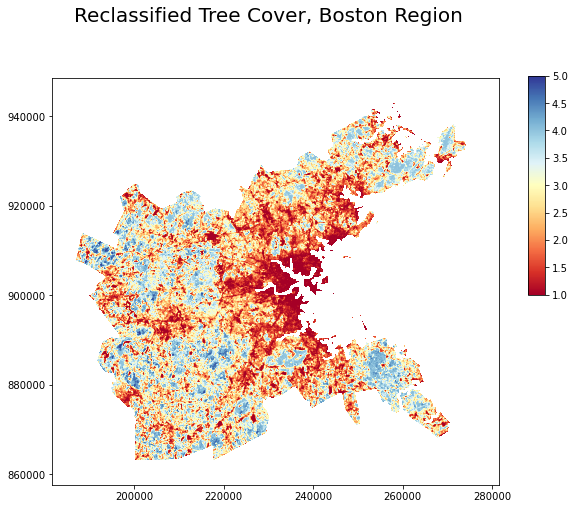

In [283]:
# Let's see what it looks like!

fig, ax = plt.subplots(figsize=(8,8))
image = ax.imshow(trees_reclass, cmap="RdYlBu", 
                  extent = (bounds.left, bounds.right, bounds.bottom, bounds.top))
fig.colorbar(image, cax = fig.add_axes([.95, 0.48, 0.03, 0.38]))
fig.suptitle("Reclassified Tree Cover, Boston Region", fontsize=20)
plt.show()

It's starting to look like I don't want to live in Somerville.... Ah well. Onward!

## Farmers Markets

Time to rasterize some farmers markets! This will be interesting - I want to create a distance raster for these. 

In [266]:
# Read in the farmers markets shapefile from MassGIS and convert the crs.

farmmarkets = gpd.read_file('data/vector/MassGIS/FARMERSMARKETS_PT/FARMERSMARKETS_PT.shp')
farmmarkets.to_crs('epsg:6491', inplace=True)

In [426]:
# Now I want to clip these farmers markets to only the extent of the Boston Region.

farmmarkets_bos = gpd.clip(farmmarkets, boston_mpo)

# Lets rasterize those farmers markets! 

farmmarkets_raster = features.rasterize(farmmarkets_bos['geometry'], 
                            out_shape=shape, fill=1, transform=transform, default_value=0)

Now to create the distance raster - we'll plot this one too, because it'll actually look like something.

In [275]:
farmmarkets_raster

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [271]:
farmmarket_distance = ndimage.distance_transform_edt(farmmarkets_raster) * res[0]

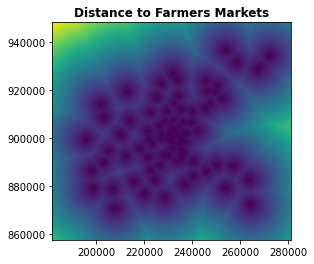

In [277]:
show(farmmarket_distance, title="Distance to Farmers Markets", transform=transform)
plt.show()

So many farmers markets! I had no idea. Let's reclassify this based on how far I really want to walk for veggies.

| Min Distance (Inclusive) | Max Distance (Exclusive) |   Suitability Level   | Suitability Score |
| :----------------------: | :----------------------: | :-------------------: | :---------------: |
|            ...           |     .5 miles (805 m)     | Very high suitability |          5        |
|     .5 miles (805 m)     |      1 mile (1609 m)     |    High suitability   |          4        |
|      1 mile (1609 m)     |     2 miles (3218 m)     |   Medium suitability  |          3        |
|      2 miles (3218 m)    |     5 miles (8046 m)     |    Low suitability    |          2        |
|      5 miles (8046 m)    |          ...             | Very low suitability  |          1        |

In [286]:
# Create a new raster, reclassify based on the rankings above.

farmers_reclass = np.full(shape, np.NaN)
farmers_reclass[farmmarket_distance < 805] = 5
farmers_reclass[(farmmarket_distance >= 805) & (farmmarket_distance < 1609)] = 4
farmers_reclass[(farmmarket_distance >= 1609) & (farmmarket_distance < 3218)] = 3
farmers_reclass[(farmmarket_distance >= 3218) & (farmmarket_distance < 8046)] = 2
farmers_reclass[farmmarket_distance >= 8046] = 1

# As ever, I want to take out the parts that aren't in the Boston region. 
# Even though we cut out the markets above, the raster still tried to think about them.

farmers_reclass_bos = farmers_reclass * mask

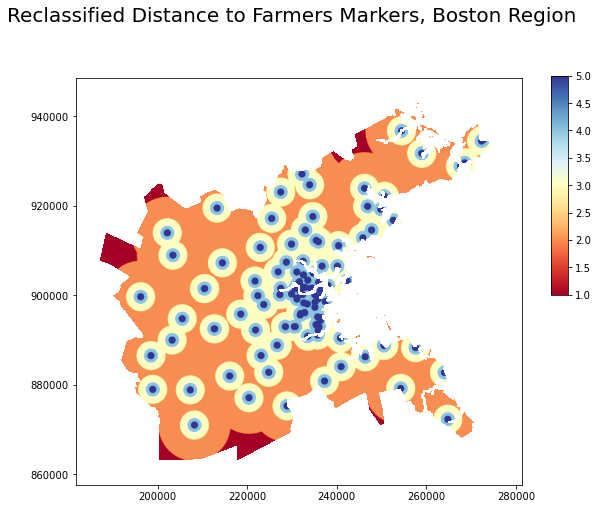

In [287]:
# Let's see what it looks like!

fig, ax = plt.subplots(figsize=(8,8))
image = ax.imshow(farmers_reclass_bos, cmap="RdYlBu", 
                  extent = (bounds.left, bounds.right, bounds.bottom, bounds.top))
fig.colorbar(image, cax = fig.add_axes([.95, 0.48, 0.03, 0.38]))
fig.suptitle("Reclassified Distance to Farmers Markers, Boston Region", fontsize=20)
plt.show()

Definintely the weirdest looking map so far. To the library!

## Libraries

Time to rasterize all these wonderful libraries! We want a distance raster here too.

In [291]:
# Read in the farmers markets shapefile from MassGIS and convert the crs.

libraries = gpd.read_file('data/vector/MassGIS/LIBRARIES_PT/LIBRARIES_PT.shp')
libraries.to_crs('epsg:6491', inplace=True)

In [424]:
# Now I want to clip these libraries to only the extent of the Boston Region.

libraries_bos = gpd.clip(libraries, boston_mpo)

# Lets rasterize those libraries! 

libraries_raster = features.rasterize(libraries_bos['geometry'], 
                                      out_shape=shape, fill=1, 
                                      transform=transform, default_value=0)

Now to create the distance raster - we'll plot this one too, because it'll actually look like something.

In [425]:
libraries_raster

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [294]:
libraries_distance = ndimage.distance_transform_edt(libraries_raster) * res[0]

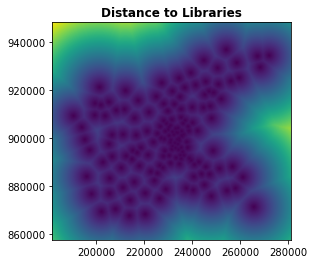

In [295]:
show(libraries_distance, title="Distance to Libraries", transform=transform)
plt.show()

Even more libraries! I had no idea. Let's reclassify this based on how far I really want to walk for books. I'm using the same ratings as the ones for farmers markets.

| Min Distance (Inclusive) | Max Distance (Exclusive) |   Suitability Level   | Suitability Score |
| :----------------------: | :----------------------: | :-------------------: | :---------------: |
|            ...           |     .5 miles (805 m)     | Very high suitability |          5        |
|     .5 miles (805 m)     |      1 mile (1609 m)     |    High suitability   |          4        |
|      1 mile (1609 m)     |     2 miles (3218 m)     |   Medium suitability  |          3        |
|      2 miles (3218 m)    |     5 miles (8046 m)     |    Low suitability    |          2        |
|      5 miles (8046 m)    |          ...             | Very low suitability  |          1        |

In [296]:
# Create a new raster, reclassify based on the rankings above.

libraries_reclass = np.full(shape, np.NaN)
libraries_reclass[libraries_distance < 805] = 5
libraries_reclass[(libraries_distance >= 805) & (libraries_distance < 1609)] = 4
libraries_reclass[(libraries_distance >= 1609) & (libraries_distance < 3218)] = 3
libraries_reclass[(libraries_distance >= 3218) & (libraries_distance < 8046)] = 2
libraries_reclass[libraries_distance >= 8046] = 1

# As ever, I want to take out the parts that aren't in the Boston region.

libraries_reclass_bos = libraries_reclass * mask

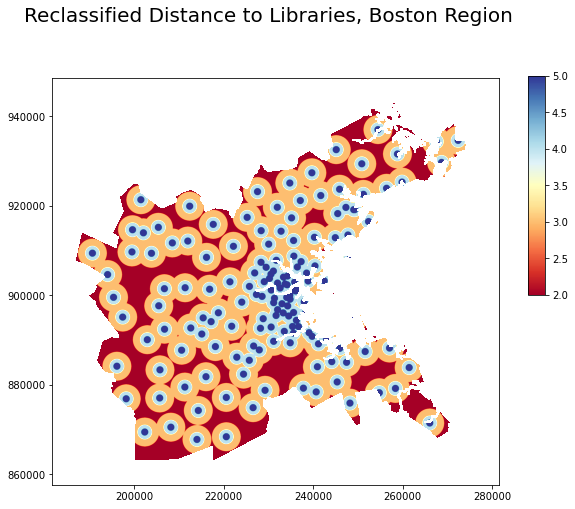

In [297]:
# Let's see what it looks like!

fig, ax = plt.subplots(figsize=(8,8))
image = ax.imshow(libraries_reclass_bos, cmap="RdYlBu", 
                  extent = (bounds.left, bounds.right, bounds.bottom, bounds.top))
fig.colorbar(image, cax = fig.add_axes([.95, 0.48, 0.03, 0.38]))
fig.suptitle("Reclassified Distance to Libraries, Boston Region", fontsize=20)
plt.show()

Another very funny map. Those polka dots definitely want me to live in Somerville, even if tree cover doesn't!

## Restaurants

Time to get OpenStreetMap in here! Let's find those restaurants. I'm going to bring in all of the restaurants in the Boston Region MPO.

In [331]:
# Create a version of the Boston Region MPO in WGS 84 - osmnx likes that better.

boston_wgs = boston_mpo.to_crs('epsg:4326')

# Bring 'em in!
polygon = boston_wgs.geometry.iat[0]
tags = {'amenity': 'restaurant'}
restaurants = ox.geometries_from_polygon(polygon, tags)
print('Retrieved', len(restaurants), 'objects.')

Retrieved 2057 objects.


That's so many restaurants. Let's see some of the relevant columns to see if this looks right.

In [332]:
cols = ['name', 'cuisine', 'addr:housenumber', 'addr:street', 'addr:city',
        'phone', 'website']

restaurants[cols].head(-5)

,name,cuisine,addr:housenumber,addr:street,addr:city,phone,website
0,Millis House of Pizza,pizza,915,Main Street,NaN,+1-508-376-8500,https://www.millishouseofpizza.com/
1,Vineripe grill,american,1281,West Roxbury Parkway,Brookline,617-278-4000,https://www.vineripegrill.com/
2,Solea,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2047,5 South Main,NaN,5,South Main Street,NaN,+1-781-383-3555,https://5southmain.com/
2048,New York Fried Chicken,fried_chicken,1179,North Main Street,NaN,NaN,NaN
2049,N & H Saigon Sub,vietnamese,1185,North Main Street,NaN,NaN,NaN
2050,Top Notch Caribbean Cuisine,jamaican,352,North Main Street,NaN,+1-781-885-2797,https://www.topnotchcaribbean.com/


Hey, at least some of them have addresses. I'd like to fix the crs on this layer and then see what they look like.

<AxesSubplot:>

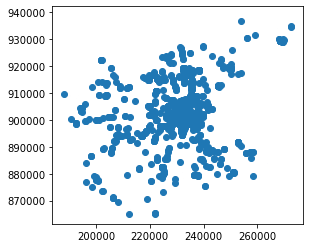

In [334]:
restaurants.to_crs('epsg:6491', inplace=True)
restaurants.plot()

Excellent. Time to rasterize those restaurants!

In [335]:
rest_raster = features.rasterize(restaurants['geometry'],
                                out_shape=shape, fill=1, transform=transform, default_value=0)

Now to create the distance raster - we'll plot this one too, because it'll actually look like something.

In [336]:
rest_raster

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [337]:
rest_distance = ndimage.distance_transform_edt(rest_raster) * res[0]

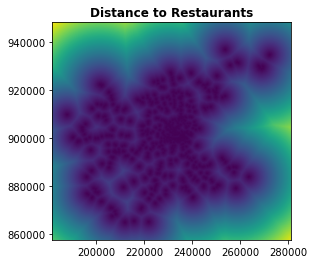

In [338]:
show(rest_distance, title="Distance to Restaurants", transform=transform)
plt.show()

Heck yeah! Food everywhere. Let's reclassify this based on how far I really want to walk. I'm using the same ratings as the ones for farmers markets and books, because ultimately if I can't get there in 30 minutes, I can't get there at all.

| Min Distance (Inclusive) | Max Distance (Exclusive) |   Suitability Level   | Suitability Score |
| :----------------------: | :----------------------: | :-------------------: | :---------------: |
|            ...           |     .5 miles (805 m)     | Very high suitability |          5        |
|     .5 miles (805 m)     |      1 mile (1609 m)     |    High suitability   |          4        |
|      1 mile (1609 m)     |     2 miles (3218 m)     |   Medium suitability  |          3        |
|      2 miles (3218 m)    |     5 miles (8046 m)     |    Low suitability    |          2        |
|      5 miles (8046 m)    |          ...             | Very low suitability  |          1        |

In [339]:
# Create a new raster, reclassify based on the rankings above.

rest_reclass = np.full(shape, np.NaN)
rest_reclass[rest_distance < 805] = 5
rest_reclass[(rest_distance >= 805) & (rest_distance < 1609)] = 4
rest_reclass[(rest_distance >= 1609) & (rest_distance < 3218)] = 3
rest_reclass[(rest_distance >= 3218) & (rest_distance < 8046)] = 2
rest_reclass[rest_distance >= 8046] = 1

# As ever, I want to take out the parts that aren't in the Boston region.

rest_reclass_bos = rest_reclass * mask

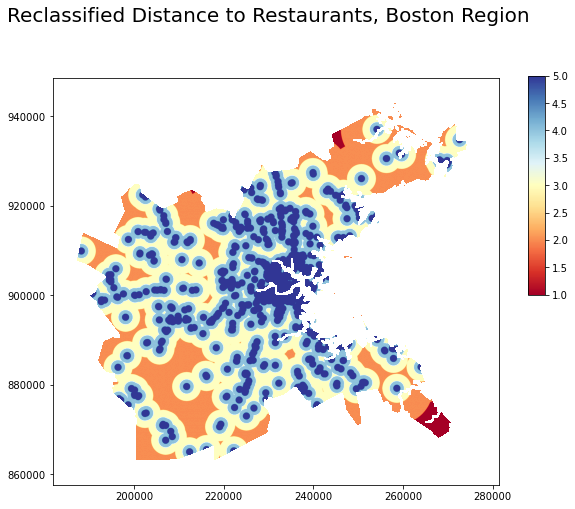

In [340]:
# Let's see what it looks like!

fig, ax = plt.subplots(figsize=(8,8))
image = ax.imshow(rest_reclass_bos, cmap="RdYlBu", 
                  extent = (bounds.left, bounds.right, bounds.bottom, bounds.top))
fig.colorbar(image, cax = fig.add_axes([.95, 0.48, 0.03, 0.38]))
fig.suptitle("Reclassified Distance to Restaurants, Boston Region", fontsize=20)
plt.show()

That's a lot of blue in the very city-ish areas in the middle, and my stomach's a pretty big factor here. I might end up in more developed ZCTAs than I expected.

## Resident Age

This one might be a little strange, using tabular data to create a raster. But we'll see what we get - I probably won't weight this very heavily anyway.

In [359]:
# Let's read in that age data!

age = pd.read_csv('data/tabular/ACSST5Y2019.S0101/ACSST5Y2019.S0101_data_with_overlays.csv', 
                  skiprows=[1])

Now we have the age data! But there are way too many variables here, we just want the important ones. Let's delete all the extra stuff.

In [505]:
cols = ['GEO_ID', 'NAME', 'S0101_C02_008E']
age_reduce = age[cols].copy()

Let's make that `NAME` column into something that'll actually work with the ZCTA geodataframe.

In [506]:
age_reduce['ZCTA5CE10'] = age_reduce['NAME'].str[5:]
age_reduce

,GEO_ID,NAME,S0101_C02_008E,ZCTA5CE10
0,8600000US01001,ZCTA5 01001,7.1,01001
1,8600000US01002,ZCTA5 01002,4.5,01002
2,8600000US01003,ZCTA5 01003,0.0,01003
3,8600000US01005,ZCTA5 01005,6.2,01005
4,8600000US01007,ZCTA5 01007,5.0,01007
...,...,...,...,...
532,8600000US02777,ZCTA5 02777,6.1,02777
533,8600000US02779,ZCTA5 02779,3.1,02779
534,8600000US02780,ZCTA5 02780,7.9,02780
535,8600000US02790,ZCTA5 02790,3.9,02790


In [487]:
age_reduce = age_reduce.set_index('ZCTA')

In [498]:
age_reduce

,GEO_ID,NAME,S0101_C02_008E
0,8600000US01001,ZCTA5 01001,7.1
1,8600000US01002,ZCTA5 01002,4.5
2,8600000US01003,ZCTA5 01003,0.0
3,8600000US01005,ZCTA5 01005,6.2
4,8600000US01007,ZCTA5 01007,5.0
...,...,...,...
532,8600000US02777,ZCTA5 02777,6.1
533,8600000US02779,ZCTA5 02779,3.1
534,8600000US02780,ZCTA5 02780,7.9
535,8600000US02790,ZCTA5 02790,3.9


Perfect. Time to join this to the ZCTAs! Then we can rasterize this thing.

In [507]:
# I'm going to merge the age data with the ZCTA geodataframe.

zips_merge = zips_clipped.merge(age_reduce, how='left', on='ZCTA5CE10')

In [508]:
zips_merge

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,GEO_ID,NAME,S0101_C02_008E
0,25,01905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"POLYGON ((243830.175 913871.662, 243877.753 91...",NaN,NaN,NaN
1,25,01904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245713.029 914796.777, 245700.484 91...",NaN,NaN,NaN
2,25,01915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"POLYGON ((250741.171 926889.812, 250787.714 92...",NaN,NaN,NaN
3,25,02462,2502462,B5,G6350,S,1369318,69749,+42.3287076,-071.2559002,N,"MULTIPOLYGON (((222090.890 897305.465, 222058....",NaN,NaN,NaN
4,25,01760,2501760,B5,G6350,S,38359306,2599042,+42.2848223,-071.3488109,N,"POLYGON ((208151.539 893024.178, 208131.535 89...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,25,02071,2502071,B5,G6350,S,2513156,33452,+42.1034247,-071.2735885,N,"MULTIPOLYGON (((217320.943 872620.799, 217310....",NaN,NaN,NaN
157,25,02343,2502343,B5,G6350,S,18146751,280250,+42.1489129,-071.0037371,N,"POLYGON ((243087.621 878272.261, 243078.760 87...",NaN,NaN,NaN
158,25,02129,2502129,B5,G6350,S,3492181,1266666,+42.3796570,-071.0614875,N,"POLYGON ((235383.264 902518.035, 235381.204 90...",NaN,NaN,NaN
159,25,02128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"POLYGON ((237939.099 904138.351, 237949.737 90...",NaN,NaN,NaN


In [509]:
zips_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 161 entries, 0 to 160
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   STATEFP10       161 non-null    object  
 1   ZCTA5CE10       161 non-null    object  
 2   GEOID10         161 non-null    object  
 3   CLASSFP10       161 non-null    object  
 4   MTFCC10         161 non-null    object  
 5   FUNCSTAT10      161 non-null    object  
 6   ALAND10         161 non-null    int64   
 7   AWATER10        161 non-null    int64   
 8   INTPTLAT10      161 non-null    object  
 9   INTPTLON10      161 non-null    object  
 10  PARTFLG10       161 non-null    object  
 11  geometry        161 non-null    geometry
 12  GEO_ID          0 non-null      object  
 13  NAME            0 non-null      object  
 14  S0101_C02_008E  0 non-null      object  
dtypes: geometry(1), int64(2), object(12)
memory usage: 20.1+ KB


In [503]:
age_reduce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   GEO_ID          537 non-null    object
 1   NAME            537 non-null    object
 2   S0101_C02_008E  537 non-null    object
 3   ZCTA            537 non-null    object
dtypes: object(4)
memory usage: 16.9+ KB


In [491]:
zips_age = zips_clipped.join(age_reduce, on='ZCTA', how='left', lsuffix='left', rsuffix='right')

KeyError: 'ZCTA'

In [492]:
zips_age.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 161 entries, 17 to 529
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   STATEFP10       161 non-null    object  
 1   ZCTA            161 non-null    object  
 2   GEOID10         161 non-null    object  
 3   CLASSFP10       161 non-null    object  
 4   MTFCC10         161 non-null    object  
 5   FUNCSTAT10      161 non-null    object  
 6   ALAND10         161 non-null    int64   
 7   AWATER10        161 non-null    int64   
 8   INTPTLAT10      161 non-null    object  
 9   INTPTLON10      161 non-null    object  
 10  PARTFLG10       161 non-null    object  
 11  geometry        161 non-null    geometry
 12  GEO_ID          0 non-null      object  
 13  NAME            0 non-null      object  
 14  S0101_C02_008E  0 non-null      object  
 15  ZCTAage         0 non-null      object  
dtypes: geometry(1), int64(2), object(13)
memory usage: 21

In [493]:
zips_clipped

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
17,25,01905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"POLYGON ((243830.175 913871.662, 243877.753 91..."
18,25,01904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245713.029 914796.777, 245700.484 91..."
21,25,01915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"POLYGON ((250741.171 926889.812, 250787.714 92..."
35,25,02462,2502462,B5,G6350,S,1369318,69749,+42.3287076,-071.2559002,N,"MULTIPOLYGON (((222090.890 897305.465, 222058...."
37,25,01760,2501760,B5,G6350,S,38359306,2599042,+42.2848223,-071.3488109,N,"POLYGON ((208151.539 893024.178, 208131.535 89..."
...,...,...,...,...,...,...,...,...,...,...,...,...
523,25,02071,2502071,B5,G6350,S,2513156,33452,+42.1034247,-071.2735885,N,"MULTIPOLYGON (((217320.943 872620.799, 217310...."
524,25,02343,2502343,B5,G6350,S,18146751,280250,+42.1489129,-071.0037371,N,"POLYGON ((243087.621 878272.261, 243078.760 87..."
526,25,02129,2502129,B5,G6350,S,3492181,1266666,+42.3796570,-071.0614875,N,"POLYGON ((235383.264 902518.035, 235381.204 90..."
527,25,02128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"POLYGON ((237939.099 904138.351, 237949.737 90..."


In [402]:
# age_reduce.info()

In [401]:
# zips_clipped.info()

In [500]:
zips_clipped = zips[zips.centroid.within(boston_mpo.geometry[10])]

# Final Calculations

Well, we've made it this far looking at one variable at a time. But what do they all look like together? Let's put these scores together and see what happens!

### Unweighted ZCTA suitability

In [422]:
living_unweighted = impervious_reclass + landcover_reclass + trees_reclass \
    + farmers_reclass_bos + libraries_reclass_bos + rest_reclass_bos

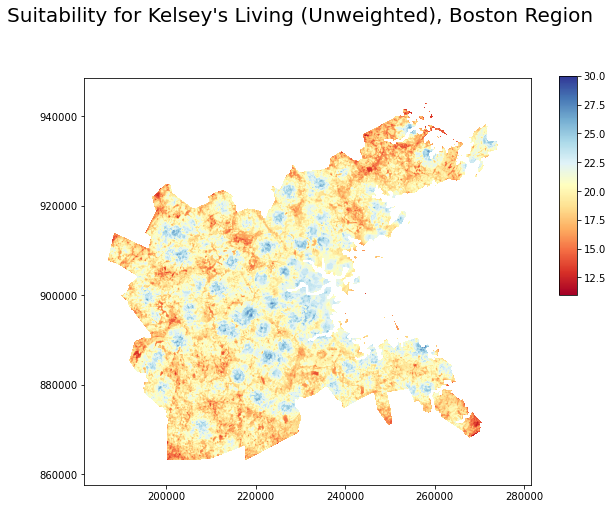

In [423]:
fig, ax = plt.subplots(figsize=(8,8))
image = ax.imshow(living_unweighted, cmap="RdYlBu", 
                  extent = (bounds.left, bounds.right, bounds.bottom, bounds.top))
fig.colorbar(image, cax = fig.add_axes([.95, 0.48, 0.03, 0.38]))
fig.suptitle("Suitability for Kelsey's Living (Unweighted), Boston Region", fontsize=20)
plt.show()

Looks like all of those market, restaurant, and library dots were worth a lot! This is pretty neat - but how about weighted? I'll use the weights below. As you can see, my stomach drives all of my decisions.

|            Component               |  Weight  |
| :--------------------------------: | :------: | 
|        Impervious surface          |    10%   | 
|            Land cover              |    10%   | 
|            Tree cover              |    10%   | 
|    Distance to farmers markets     |    20%   | 
|       Distance to libraries        |    15%   | 
|      Distance to restaurants       |    20%   | 
| Percent of residents in early 30's |    15%   | 

In [421]:
living_weighted = (impervious_reclass*.1) + (landcover_reclass*.1) \
    + (trees_reclass*.1) + (farmers_reclass_bos*.20) \
    + (libraries_reclass_bos*.15) + (rest_reclass_bos*.20)

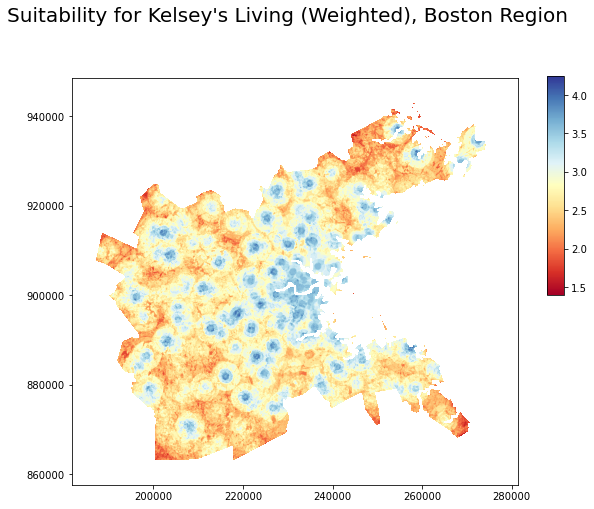

In [420]:
fig, ax = plt.subplots(figsize=(8,8))
image = ax.imshow(living_weighted, cmap="RdYlBu", 
                  extent = (bounds.left, bounds.right, bounds.bottom, bounds.top))
fig.colorbar(image, cax = fig.add_axes([.95, 0.48, 0.03, 0.38]))
fig.suptitle("Suitability for Kelsey's Living (Weighted), Boston Region", fontsize=20)
plt.show()

Yep, that city area just keeps looking better and better. I can always ride my bike to the Fells.

But what if we look at zonal stats and see which ZCTA is the most suitable?

I need to start by resetting the index on my ZCTA gdf, to make sure the mean values can map to it.

In [512]:
zips_reset = zips_clipped.reset_index()
zips_reset

,index,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,17,25,01905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"POLYGON ((243830.175 913871.662, 243877.753 91..."
1,18,25,01904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245713.029 914796.777, 245700.484 91..."
2,21,25,01915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"POLYGON ((250741.171 926889.812, 250787.714 92..."
3,35,25,02462,2502462,B5,G6350,S,1369318,69749,+42.3287076,-071.2559002,N,"MULTIPOLYGON (((222090.890 897305.465, 222058...."
4,37,25,01760,2501760,B5,G6350,S,38359306,2599042,+42.2848223,-071.3488109,N,"POLYGON ((208151.539 893024.178, 208131.535 89..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,523,25,02071,2502071,B5,G6350,S,2513156,33452,+42.1034247,-071.2735885,N,"MULTIPOLYGON (((217320.943 872620.799, 217310...."
157,524,25,02343,2502343,B5,G6350,S,18146751,280250,+42.1489129,-071.0037371,N,"POLYGON ((243087.621 878272.261, 243078.760 87..."
158,526,25,02129,2502129,B5,G6350,S,3492181,1266666,+42.3796570,-071.0614875,N,"POLYGON ((235383.264 902518.035, 235381.204 90..."
159,527,25,02128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"POLYGON ((237939.099 904138.351, 237949.737 90..."


Looks good. Now let's create those zonal stats for the unweighted version and map it!

In [541]:
unweighted_stats = pd.DataFrame(zonal_stats(zips_clipped, living_unweighted, 
                                affine=transform, stats=['mean'], nodata = np.NaN))
zips_unweighted = zips_reset.join(unweighted_stats)

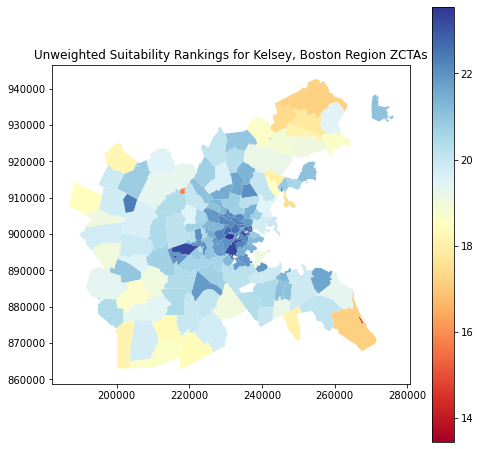

In [539]:
zips_unweighted.plot(column = 'mean', cmap="RdYlBu", figsize=(8,8), legend=True)
plt.title("Unweighted Suitability Rankings for Kelsey, Boston Region ZCTAs")
plt.show()

In this unweighted universe, what's the worst ranked ZCTAs for me to live in?

In [546]:
sort_unweighted = zips_unweighted.sort_values(by='mean', ascending=True)
sort_unweighted.head(1)

,index,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,mean
72,244,25,02047,2502047,B5,G6350,S,619346,21837,+42.1337338,-070.6858599,N,"POLYGON ((267358.196 875819.198, 267395.076 87...",13.446043


02047 it is! Don't think I'll go hang out there. What about the best?

In [547]:
sort_unweighted = zips_unweighted.sort_values(by='mean', ascending=False)
sort_unweighted.head(1)

,index,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,mean
84,305,25,02446,2502446,B5,G6350,S,3333660,11957,+42.3435034,-071.1222479,N,"POLYGON ((230796.803 900058.050, 230823.582 90...",23.542519


02446 is in first place with a mean suitability score of 23.54. Pretty darn cool.

But what about the weighted version?

In [549]:
weighted_stats = pd.DataFrame(zonal_stats(zips_clipped, living_weighted, 
                                affine=transform, stats=['mean'], nodata = np.NaN))
zips_weighted = zips_reset.join(weighted_stats)

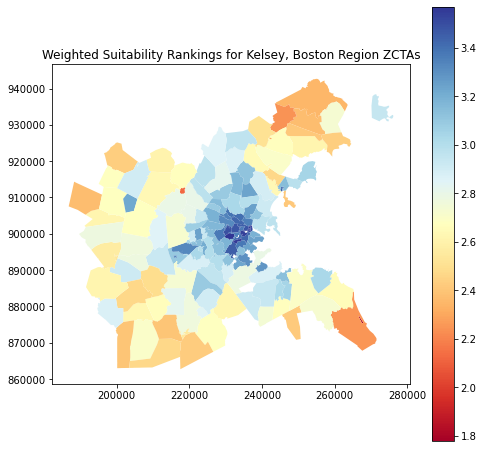

In [550]:
zips_weighted.plot(column = 'mean', cmap="RdYlBu", figsize=(8,8), legend=True)
plt.title("Weighted Suitability Rankings for Kelsey, Boston Region ZCTAs")
plt.show()

Yep, those internal zip codes are calling to me. Out of all that blue, what's the best ZCTA for me?

In [551]:
sort_weighted = zips_weighted.sort_values(by='mean', ascending=False)
sort_weighted.head(1)

,index,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,mean
84,305,25,02446,2502446,B5,G6350,S,3333660,11957,+42.3435034,-071.1222479,N,"POLYGON ((230796.803 900058.050, 230823.582 90...",3.569268


Again 02446 wins! That's quite a coup. What about the worst? I see that dark red spot out in the northwest...

In [552]:
sort_weighted = zips_weighted.sort_values(by='mean', ascending=True)
sort_weighted.head(1)

,index,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,mean
72,244,25,02047,2502047,B5,G6350,S,619346,21837,+42.1337338,-070.6858599,N,"POLYGON ((267358.196 875819.198, 267395.076 87...",1.776739


Interesting - weighting changed nothing! It's 02047 again.

It turns out that the most suitable place for me to live in the Boston region is Brookline, and the worst is Humarock. I had never even heard of it - apparently only 180 people live there. Brookline's okay by me!